# RL solutions for combinatorial games: Temporal Difference Methods

**Refer [the notebook on Monte Carlo Control](nim_MC_on_policy.ipynb) for the problem set up**

In [31]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [32]:
np.random.seed(42)

In [33]:
# A Simple Nim Game
class SimpleNim:
    def __init__(self, state):
        self.heaps = np.array(state, dtype=int)
        self.turn = 0
        self.num_heaps = len(self.heaps)

    def get_state(self):
        if isinstance(self.heaps, list):
            return tuple(self.heaps)
        else:
            return tuple(self.heaps.tolist())

    def get_num_heaps(self):
        return self.num_heaps

    def get_heap_size(self, heap_index):
        if 0 <= heap_index < self.num_heaps:
            return self.heaps[heap_index]
        return None

    def is_game_over(self):
        return all(pebbles == 0 for pebbles in self.heaps)

    def make_move(self, heap_index, num_pebbles):
        if self.is_game_over():
            return False

        # Validate the move
        if 0 <= heap_index < self.num_heaps and 0 < num_pebbles <= self.heaps[heap_index]:
            self.heaps[heap_index] -= num_pebbles
            self.turn = 1 - self.turn  # Switch turns
            return True
        return False

    def winner(self):
        if self.is_game_over():
            return 1-self.turn
        return None

In [34]:
def nim_sum(s):
    xor = 0
    for heap in s:
        xor ^= heap
    return xor

In [35]:
# Function to play the optimal move in Nim, end on a zero nim-sum
def play_optimal(game):
    if game.is_game_over():
        return None

    nim_sum_value = nim_sum(game.get_state())
    heaps = game.get_state()
    for i in range(game.get_num_heaps()):
        if heaps[i] > 0 and (nim_sum_value ^ heaps[i]) < heaps[i]:
            # Make the move that results in a zero nim-sum
            game.make_move(i, heaps[i] - (nim_sum_value ^ heaps[i]))
            return True
    # If no optimal move is found
    index = np.random.randint(0, game.get_num_heaps())
    while game.get_heap_size(index) == 0:
        index = np.random.randint(0, game.get_num_heaps())
    game.make_move(index, 1)

In [36]:
def play_random(game):
    if game.is_game_over():
        return
    heaps = game.get_state()

    index = np.random.randint(0, len(heaps))
    while heaps[index] == 0:
        index = np.random.randint(0, len(heaps))

    num_pebbles = np.random.randint(1, heaps[index] + 1)
    game.make_move(index, num_pebbles)

In [37]:
# opponent that plays optimal with probability prob_optimal
def play_optimal_random(game, prob_optimal=1.0):
    random_choice = np.random.rand()
    if random_choice < prob_optimal:
        play_optimal(game)
    else:
        play_random(game)

In [38]:
# simple simulation of a nim game with both players using the optimal strategy
heaps = [10] * 3
game = SimpleNim(heaps)
while not game.is_game_over():
    play_optimal(game)
    print(game.get_state())
print("The winner is Player ", game.winner())

(0, 10, 10)
(0, 10, 9)
(0, 9, 9)
(0, 9, 8)
(0, 8, 8)
(0, 8, 7)
(0, 7, 7)
(0, 7, 6)
(0, 6, 6)
(0, 5, 6)
(0, 5, 5)
(0, 5, 4)
(0, 4, 4)
(0, 4, 3)
(0, 3, 3)
(0, 3, 2)
(0, 2, 2)
(0, 2, 1)
(0, 1, 1)
(0, 1, 0)
(0, 0, 0)
The winner is Player  0


## Defining State and Action Spaces:
**The State** is given by a configuration of heaps($\N_0$ means the set of naturals that includes zero):
$$ \mathcal S = \N_0^h $$
where h is the number of heaps
**Actions** are given by two tuples of heap number and number of pebbles to be taken out:
$$ \mathcal A(s) = H(s) \times \N $$ 
where $\N$ does not include zero and $H(s)$ is the set of heaps having non zero number of pebbles in the state s

In [39]:
# helper function that evaluates a policy based on whether the turn ends on a nim sum of 0
def is_optimal(s, a):
    s = list(s)
    if a[1] == 0: return False
    s[a[0]] -= a[1]
    return nim_sum(s) == 0

In [40]:
# for simplicity consider the version of the problem that starts off with same number of pebbles in each heap
num_heaps = 3
initial_pebbles = 5
max_episodes = 1000000

start_state = (initial_pebbles,) * num_heaps

In [41]:
# Defining a class for epsilon greedy policy that has methods to update epsilon to account for GLIE conditions and to sample from epsilon greedy policy
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon or len(Q[s]) == 0:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        else:
            return max(Q[s], key=Q[s].get)

    # Returns a policy that does not explore
    def final_policy(self, s, Q):
        if s not in Q or len(Q[s]) == 0:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [42]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        return max(Q[s], key=Q[s].get)

    def final_policy(self, s, Q):
        if s not in Q:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [43]:
def sample_step_reward_zero_on_loss(game, A, prob_optimal=1.0):
    game.make_move(A[0],A[1])
    play_optimal_random(game, prob_optimal)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    else: return 0, S_next

#### The red dashed line on the plot indicates the true value of the state

In [44]:
def plot_start_state_returns(Q_start_state_history):
    plt.plot(Q_start_state_history)
    plt.hlines(1.0, 0, len(Q_start_state_history), colors='r', linestyles='dashed')
    plt.xlabel('Episodes')
    plt.ylabel('Return from Start State')
    plt.title('Return from Start State Over Episodes')
    plt.show()

In [45]:
def play_against_optimal(Q, start_state, policy):
    game = SimpleNim(start_state)
    while not game.is_game_over():
        A = policy.policy(game.get_state(), Q)
        if not game.make_move(A[0], A[1]):
            raise ValueError("Invalid move made by the policy.")
        play_optimal(game)

    return game.winner() == 0  # Returns True if the player wins

In [46]:
def optimal_value_function(state, reward_on_loss=0.0):
    if nim_sum(state) == 0:
        return reward_on_loss
    return 1.0

In [47]:
def find_value_error(Q, curr_state, policy, reward_on_loss=0.0):
    curr_action = policy.final_policy(curr_state, Q)
    optimal_value = optimal_value_function(curr_state, reward_on_loss)
    if curr_state not in Q or curr_action not in Q[curr_state]:
        return optimal_value
    return optimal_value - Q[curr_state][curr_action]


In [48]:
def plot_over_episodes(errors, title="Bellman Errors Over Episodes", ylabel="Bellman Error"):
    plt.plot(errors)
    plt.xlabel('Episodes')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### SARSA: On policy TD(0)

SARSA (State-Action-Reward-State-Action) is an on-policy temporal-difference (TD) learning algorithm used to estimate the action-value function $Q(s, a)$ using Bootstrapping i.e. it makes use of an estimate of $Q(s, a)$(a guess) to update our current estimate of $Q(s, a)$(another guess) for a particular state-action pair using a sample reward over one step.

Bootstrapping basically refers to how we are using a guess to update another guess using some experience information.

The update rule is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]
$$

Here:

* $\alpha$ is the learning rate,
* $\gamma$ is the discount factor,
* $(s_t, a_t, r_{t+1}, s_{t+1}, a_{t+1})$ is the observed transition following the current policy.

In [ ]:
# SARSA
def sarsa(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, prob_optimal=1.0, epsilon_schedule_update=None):
    Q = {} # take default to be zero

    Q_history = []  # To keep track of the Q-value over episodes for plotting

    bellman_errors = []  # To track the Bellman errors

    value_errors = []  # To track the value errors

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}
            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]
            Q[S][A] = Q[S][A] + step_size*delta

            A = A1
            S = S1

        if epsilon_schedule is not None: policy.update(epsilon=epsilon_schedule[i])
        elif epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        else: # Default epsilon value if no schedule is provided
            policy.update(1/(i+1))

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

        # Track the bellman error for every 100 episodes
        if i % 100 == 0:
            value_error_value = find_value_error(Q, start_state, policy, reward_on_loss=(0.0 if sample_step == sample_step_reward_zero_on_loss else -1.0))
            value_errors.append(value_error_value + value_errors[-1] if value_errors else value_error_value)
            bellman_errors.append(bellman_errors[-1] + delta if bellman_errors else delta)

    print("Q values at start state:", Q.get(start_state, {}))

    return policy, Q, Q_history, bellman_errors, value_errors

In [50]:
import itertools

def evaluate_on_winning_positions(policy, Q):
    fumbles = 0
    num_winning_pos = 0
    for s in itertools.product(range(initial_pebbles), repeat=num_heaps):
        if s == (0)*num_heaps: continue
        action = policy.final_policy(s, Q)
        if nim_sum(s) == 0: continue
        if not is_optimal(s, action):
            fumbles+=1
        num_winning_pos+=1
    return fumbles, num_winning_pos

In [51]:
def evaluate_using_fumbles(policy, Q):
    fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
    print('number of fumbles:', fumbles)
    print('total number of winning positions:', num_winning_pos)
    print('percentage of winning positions fumbled: {:.2f} %'.format(fumbles/num_winning_pos*100))

In [52]:
# Epsilon Greedy and exploring starts
policy, Q, history_sarsa_zero_rew, bellman_errors_sarsa_zero_rew, value_errors_sarsa_zero_rew = sarsa()

print(Q[start_state] if start_state in Q else "No Q-values for start state")
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:28<00:00, 34515.51it/s]

Q values at start state: {(0, 4): 0.0, (0, 3): 0.0, (1, 2): 0.0, (1, 4): 0.0, (0, 5): 0.9973622654323692, (1, 3): 0.0, (0, 1): 0.0, (0, 2): 0.0, (1, 1): 0.0, (2, 1): 0.0, (1, 5): 0.9978818158161492, (2, 2): 0.0, (2, 5): 0.9976416997465564, (2, 4): 0.0, (2, 3): 0.0}
{(0, 4): 0.0, (0, 3): 0.0, (1, 2): 0.0, (1, 4): 0.0, (0, 5): 0.9973622654323692, (1, 3): 0.0, (0, 1): 0.0, (0, 2): 0.0, (1, 1): 0.0, (2, 1): 0.0, (1, 5): 0.9978818158161492, (2, 2): 0.0, (2, 5): 0.9976416997465564, (2, 4): 0.0, (2, 3): 0.0}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


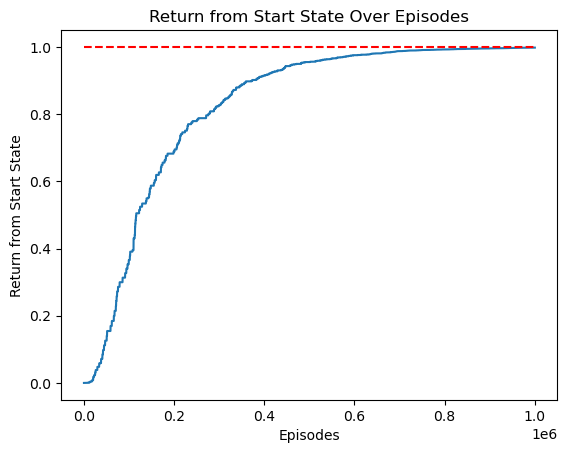

In [53]:
plot_start_state_returns(history_sarsa_zero_rew)

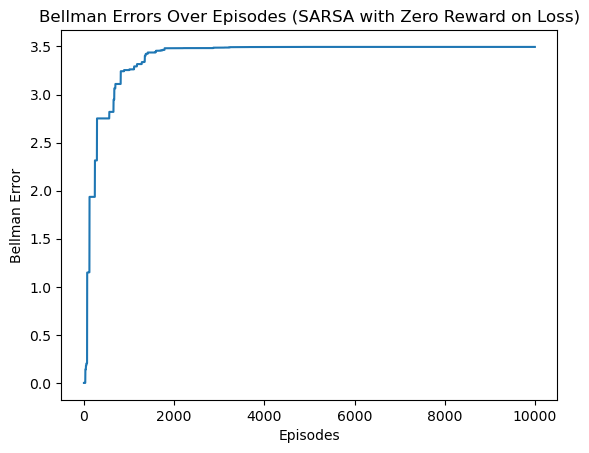

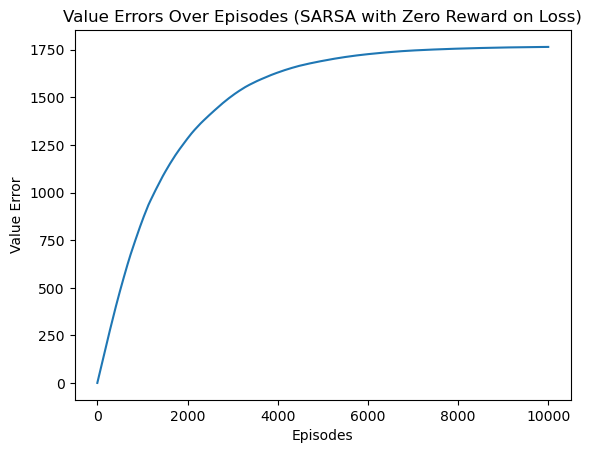

In [54]:
plot_over_episodes(bellman_errors_sarsa_zero_rew, title="Bellman Errors Over Episodes (SARSA with Zero Reward on Loss)", ylabel="Bellman Error")
plot_over_episodes(value_errors_sarsa_zero_rew, title="Value Errors Over Episodes (SARSA with Zero Reward on Loss)", ylabel="Value Error")

In [55]:
# Apply the new rewards model with negative rewards for losses
def sample_step_reward_negative_on_loss(game, A, prob_optimal=1.0):
    game.make_move(A[0],A[1])
    play_optimal_random(game, prob_optimal=prob_optimal)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    elif game.is_game_over(): return -1, S_next
    else: return 0, S_next

In [56]:
# Epsilon Greedy with exploring starts negative rewards on losing
policy, Q, history_sarsa_neg_rewards, bellman_errors_sarsa_neg_rewards, value_errors_sarsa_neg_rewards = sarsa(sample_step=sample_step_reward_negative_on_loss)

print(Q[start_state])
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:29<00:00, 33627.04it/s]

Q values at start state: {(1, 3): -0.996507322041115, (0, 5): 0.9976522664289698, (2, 3): -0.9966357369779398, (2, 1): -0.9962726455071593, (1, 4): -0.9956535021931142, (0, 1): -0.9965990098013229, (2, 4): -0.9981353171460092, (2, 2): -0.9952486103366119, (0, 3): -0.9944263379193132, (1, 2): -0.9950829855804151, (2, 5): 0.9980263467909625, (0, 4): -0.99575221419605, (0, 2): -0.9969434651300366, (1, 1): -0.9943226431861314, (1, 5): 0.9981040572300781}
{(1, 3): -0.996507322041115, (0, 5): 0.9976522664289698, (2, 3): -0.9966357369779398, (2, 1): -0.9962726455071593, (1, 4): -0.9956535021931142, (0, 1): -0.9965990098013229, (2, 4): -0.9981353171460092, (2, 2): -0.9952486103366119, (0, 3): -0.9944263379193132, (1, 2): -0.9950829855804151, (2, 5): 0.9980263467909625, (0, 4): -0.99575221419605, (0, 2): -0.9969434651300366, (1, 1): -0.9943226431861314, (1, 5): 0.9981040572300781}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


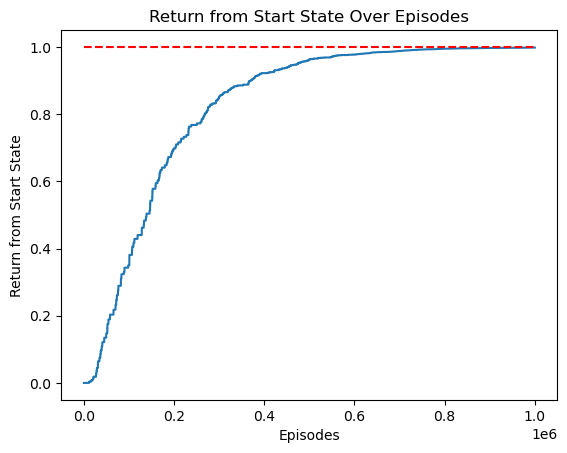

In [57]:
plot_start_state_returns(history_sarsa_neg_rewards)

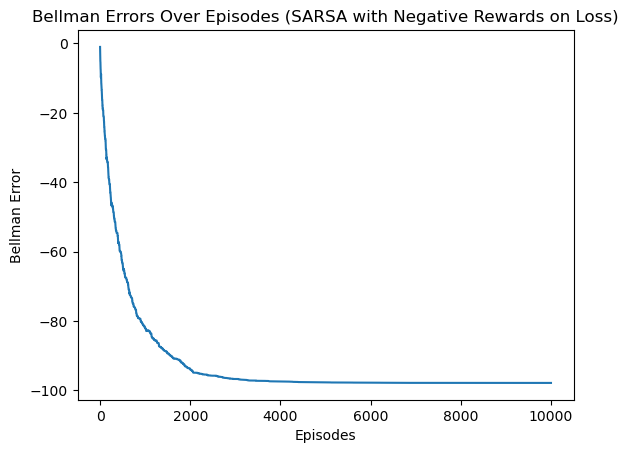

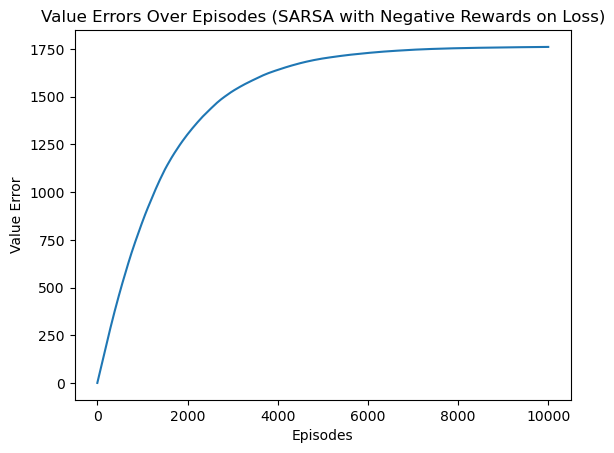

In [58]:
plot_over_episodes(bellman_errors_sarsa_neg_rewards, title="Bellman Errors Over Episodes (SARSA with Negative Rewards on Loss)", ylabel="Bellman Error")
plot_over_episodes(value_errors_sarsa_neg_rewards, title="Value Errors Over Episodes (SARSA with Negative Rewards on Loss)", ylabel="Value Error")

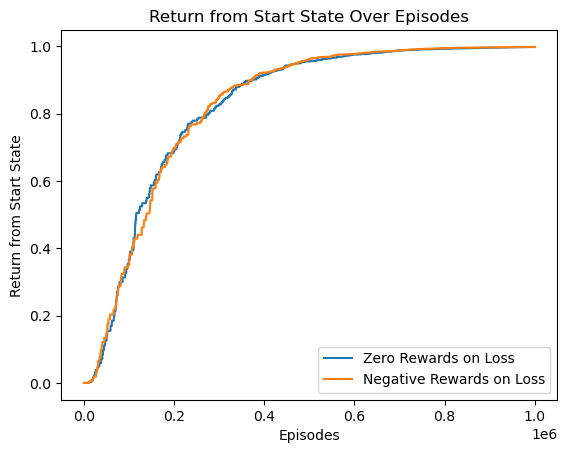

In [59]:
# Compare performance when negative rewards vs with positive rewards
plt.plot(history_sarsa_zero_rew, label='Zero Rewards on Loss')
plt.plot(history_sarsa_neg_rewards, label='Negative Rewards on Loss')
plt.xlabel('Episodes')
plt.ylabel('Return from Start State')
plt.title('Return from Start State Over Episodes')
plt.legend()
plt.show()

In [60]:
# Suboptimal opponent
policy, Q, history_sarsa_suboptimal_opp, bellman_errors_sarsa_suboptimal_opp, value_errors_sarsa_suboptimal_opp = sarsa(policy=EpsilonGreedyPolicy(), exploring_starts=True, prob_optimal=0.6)
print(Q[start_state])

100%|██████████| 1000000/1000000 [00:32<00:00, 31215.25it/s]

Q values at start state: {(0, 2): 0.870724467495521, (0, 4): 0.8590002348516965, (2, 3): 0.8690577464206029, (2, 1): 0.8586600156944337, (0, 1): 0.8676954152949871, (1, 3): 0.8810127535228341, (0, 3): 0.8771745851163291, (2, 2): 0.8587799138859546, (1, 5): 0.9966234584638087, (1, 4): 0.8416513772859947, (1, 1): 0.8535435899160815, (2, 4): 0.8340023302126536, (0, 5): 0.9951039711695859, (1, 2): 0.8781464043366418, (2, 5): 0.9977600471780239}
{(0, 2): 0.870724467495521, (0, 4): 0.8590002348516965, (2, 3): 0.8690577464206029, (2, 1): 0.8586600156944337, (0, 1): 0.8676954152949871, (1, 3): 0.8810127535228341, (0, 3): 0.8771745851163291, (2, 2): 0.8587799138859546, (1, 5): 0.9966234584638087, (1, 4): 0.8416513772859947, (1, 1): 0.8535435899160815, (2, 4): 0.8340023302126536, (0, 5): 0.9951039711695859, (1, 2): 0.8781464043366418, (2, 5): 0.9977600471780239}


number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


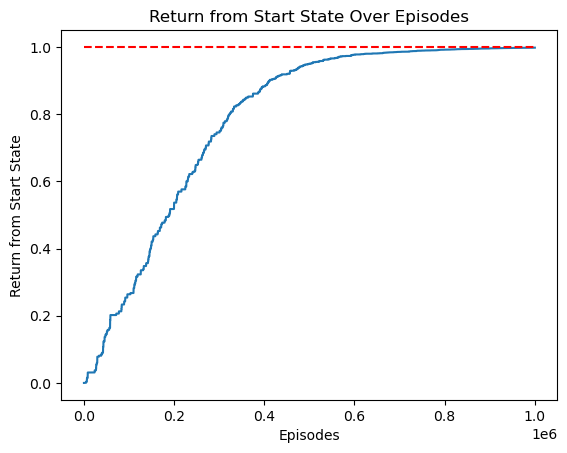

In [61]:
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_sarsa_suboptimal_opp)

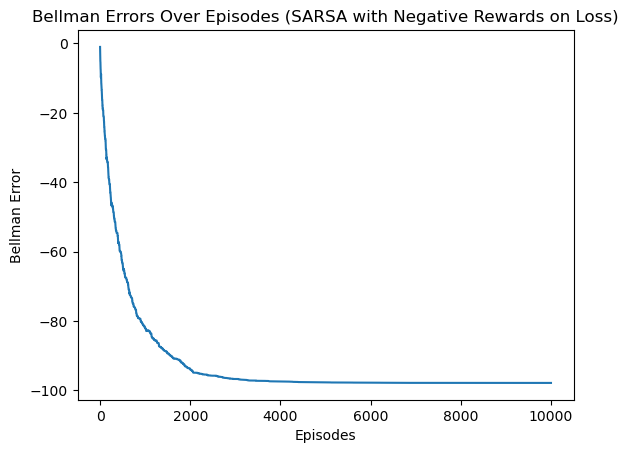

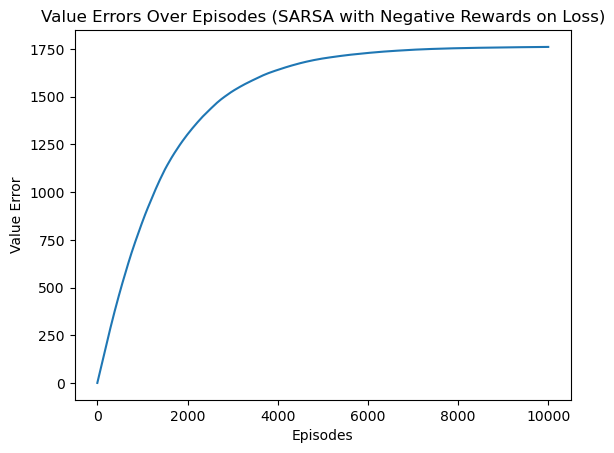

In [ ]:
plot_over_episodes(bellman_errors_sarsa_suboptimal_opp, title="Bellman Errors Over Episodes (SARSA with Negative Rewards on Loss)", ylabel="Bellman Error")
plot_over_episodes(value_errors_sarsa_suboptimal_opp, title="Value Errors Over Episodes (SARSA with Negative Rewards on Loss)", ylabel="Value Error")

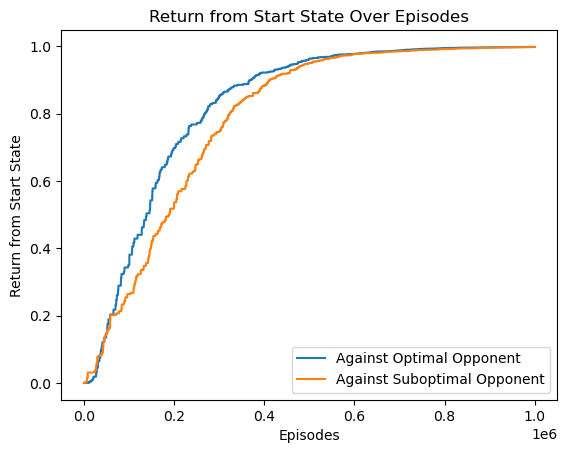

In [63]:
# compare optimal opponent vs suboptimal opponent
plt.plot(history_sarsa_neg_rewards, label='Against Optimal Opponent')
plt.plot(history_sarsa_suboptimal_opp, label='Against Suboptimal Opponent')
plt.xlabel('Episodes')
plt.ylabel('Return from Start State')
plt.title('Return from Start State Over Episodes')
plt.legend()
plt.show()

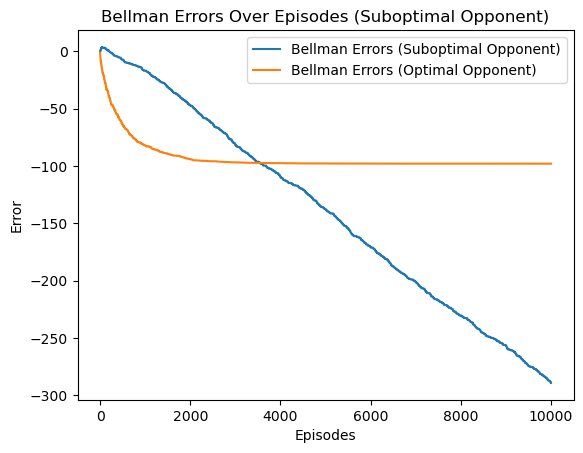

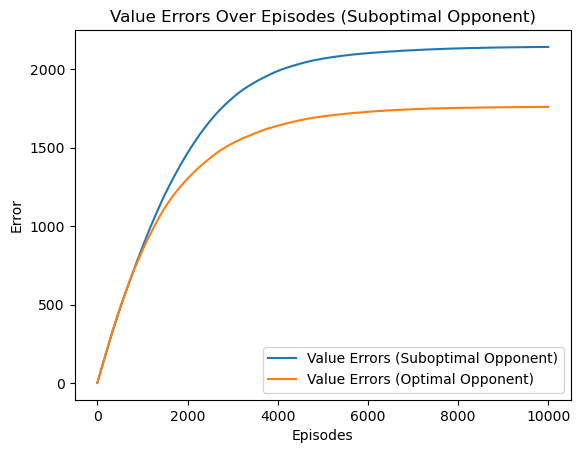

In [64]:
# Compare bellman errors and value errors for suboptimal opponent with optimal opponent
plt.plot(bellman_errors_sarsa_suboptimal_opp, label='Bellman Errors (Suboptimal Opponent)')
plt.plot(bellman_errors_sarsa_neg_rewards, label='Bellman Errors (Optimal Opponent)')
plt.xlabel('Episodes')
plt.ylabel('Error')
plt.title('Bellman Errors Over Episodes (Suboptimal Opponent)')
plt.legend()
plt.show()

plt.plot(value_errors_sarsa_suboptimal_opp, label='Value Errors (Suboptimal Opponent)')
plt.plot(value_errors_sarsa_neg_rewards, label='Value Errors (Optimal Opponent)')
plt.xlabel('Episodes')
plt.ylabel('Error')
plt.title('Value Errors Over Episodes (Suboptimal Opponent)')
plt.legend()
plt.show()

**Observation:** Negative rewards on loss performs marginally better than the reward model with zero reward on loss, it seems like initially negative rewards on loss is forced to explore more which allows it to perform better later

**Speculation:** Is this an effect of optimistic value estimates?
- For the Multi-Armed Bandit Problem with optimistic initialization of the reward(refer [[4](README.md)]), the bandit explores better
- **Intuition:** There are some initial estimates of rewards, on actually trying an action, the reward is less than expected and less than that expected from the other actions, so the algorithm is less likely to try the same action again until the other actions are explored reasonably well so that their optimistic estimates are corrected.
- This forces exploration, can the case of negative rewards be thought of in a similar way? The agent initially always loses to the opponent and gets a negative reward even if it chooses the initial action optimally, it will likely fumble
- So the agent is forced to explore all actions due to the optimistic non-negative estimate

In [65]:
# providing a way to check performance more reliably
def evaluate_using_fumbles_averaged(train, num_iters=5, prob_optimal=None, sample_step=sample_step_reward_negative_on_loss, play_against_optimal_until=None, epsilon_schedule=None, epsilon_schedule_update=None):
    num_winning_pos = 0
    total_fumbles = 0
    for i in range(num_iters):
        print(f'iteration {i+1}')
        if prob_optimal is None:
            if play_against_optimal_until is not None:
                policy, Q, history = train(sample_step=sample_step, play_against_optimal_until=play_against_optimal_until, epsilon_schedule=epsilon_schedule, epsilon_schedule_update=epsilon_schedule_update)
            else:
                policy, Q, history = train(sample_step=sample_step, epsilon_schedule=epsilon_schedule, epsilon_schedule_update=epsilon_schedule_update)
        else:
            policy, Q, history = train(sample_step=sample_step, prob_optimal=prob_optimal, epsilon_schedule=epsilon_schedule, epsilon_schedule_update=epsilon_schedule_update)

        fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
        total_fumbles += fumbles
    return total_fumbles, num_winning_pos

In [66]:
# num_iters = 5
# total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa, num_iters=num_iters)
# print('average number of fumbles: ', total_fumbles/num_iters)
# print('fumble rate: {:.2f}%'.format(total_fumbles/float(num_winning_pos*num_iters)*100))

### Q-learning: Off-policy TD(0) Control

Q-learning is an off-policy temporal-difference (TD) algorithm used to learn the optimal action-value function $Q^*(s, a)$, independent of the agent's behavior policy. It uses the maximum estimated value of the next state to update the current Q-value, allowing it to learn the optimal policy even while following a non-optimal (e.g. $\epsilon$-greedy) policy.

The update rule is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$

Here:

* $\alpha$ is the learning rate,
* $\gamma$ is the discount factor,
* $r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a)$ is called the target
* The update targets the best possible next action, not necessarily the one actually taken.

**How is this different from SARSA?**  
The update rule looks very similar to SARSA but there is a subtle but very important difference.
- The difference lies in the target, specifically in the action chosen for the Q-value.
- The action is the one that is greedy with respect to the Q-function. This means that this action is chosen to be the greedy action no matter what the policy dictates.
- This property of Q-learning is what makes it an **Off-policy** method because the target doesn't depend on the current policy which means that the policy used for exploration(updating the Q-values) need not be the same as that which is used for control, while SARSA targets have actions chosen according to the current policy.

In [ ]:
# Q-Learning
def qlearning(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, prob_optimal=1.0, epsilon_schedule_update=None):
    Q = {} # take default to be zero

    Q_history = []  # To keep track of the Q-value over episodes for plotting

    bellman_errors = []  # To track the Bellman errors

    value_errors = []  # To track the value errors

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal)

            # Initialize Q-values if not present
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0

            if S1 not in Q:
                Q[S1] = {}

            # Q-learning update: use max Q-value for next state (off-policy)
            if len(Q[S1]) > 0:
                max_Q_next = max(Q[S1].values())
            else:
                max_Q_next = 0

            # Q-learning update rule
            target = R + gamma * max_Q_next
            delta = target - Q[S][A]
            Q[S][A] = Q[S][A] + step_size * delta

            # Move to next state and choose next action using current policy
            S = S1
            if not game.is_game_over():
                A = policy.policy(S, Q)

        # Update epsilon schedule
        if epsilon_schedule is not None:
            policy.update(epsilon=epsilon_schedule[i])
        elif epsilon_schedule_update is not None:
            epsilon_schedule_update(policy, i)
        else: # Default epsilon value if no schedule is provided
            policy.update(1/(i+1))

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

        # Track the bellman error for every 100 episodes
        if i % 100 == 0:
            value_error_value = find_value_error(Q, start_state, policy, reward_on_loss=(0.0 if sample_step == sample_step_reward_zero_on_loss else -1.0))
            value_errors.append(value_error_value + value_errors[-1] if value_errors else value_error_value)
            bellman_errors.append(bellman_errors[-1] + delta if bellman_errors else delta)

    print("Q values at start state:", Q.get(start_state, {}))

    return policy, Q, Q_history, bellman_errors, value_errors

In [68]:
policy, Q, history_qlearning, bellman_errors_qlearning, value_errors_qlearning = qlearning(sample_step=sample_step_reward_negative_on_loss)

print(Q[start_state])
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:30<00:00, 32830.56it/s]

Q values at start state: {(2, 5): 0.9977852401156581, (1, 4): -0.9950453234127825, (2, 1): -0.9976726854086218, (0, 2): -0.9956718012511495, (0, 3): -0.9950636264534113, (1, 2): -0.9964333020103425, (0, 1): -0.9974728967919996, (2, 4): -0.9960971059657373, (1, 1): -0.9960547793783603, (2, 3): -0.9958081354632096, (0, 4): -0.9978704058084789, (0, 5): 0.9950229243304972, (1, 3): -0.9934888643397353, (1, 5): 0.9979971185197465, (2, 2): -0.993706561086597}
{(2, 5): 0.9977852401156581, (1, 4): -0.9950453234127825, (2, 1): -0.9976726854086218, (0, 2): -0.9956718012511495, (0, 3): -0.9950636264534113, (1, 2): -0.9964333020103425, (0, 1): -0.9974728967919996, (2, 4): -0.9960971059657373, (1, 1): -0.9960547793783603, (2, 3): -0.9958081354632096, (0, 4): -0.9978704058084789, (0, 5): 0.9950229243304972, (1, 3): -0.9934888643397353, (1, 5): 0.9979971185197465, (2, 2): -0.993706561086597}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


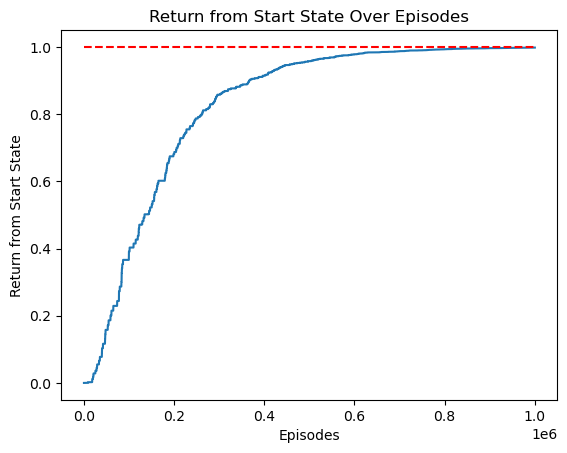

In [69]:
plot_start_state_returns(history_qlearning)

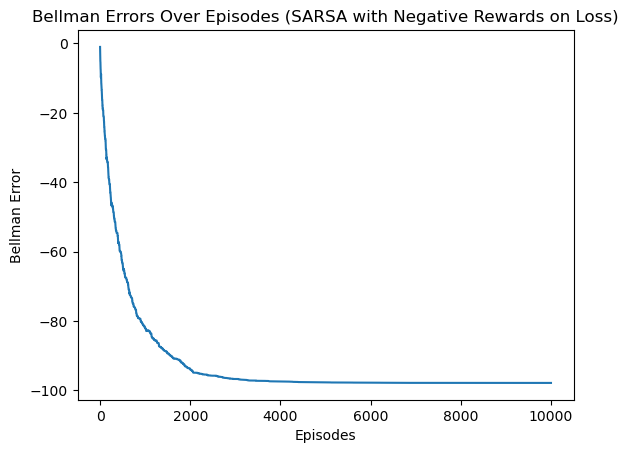

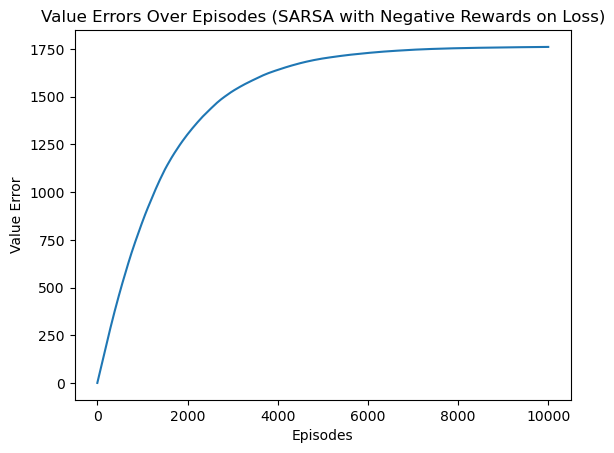

In [ ]:
plot_over_episodes(bellman_errors_qlearning, title="Bellman Errors Over Episodes (Q-Learning with Negative Rewards on Loss)", ylabel="Bellman Error")
plot_over_episodes(value_errors_qlearning, title="Value Errors Over Episodes (Q-Learning with Negative Rewards on Loss)", ylabel="Value Error")

In [71]:
def get_exponential_schedule(decay):
    epsilon_schedule = []
    for i in range(max_episodes):
        epsilon_schedule.append((1-decay)*(decay**i))
    return epsilon_schedule

In [72]:
# policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, epsilon_schedule=get_exponential_schedule(decay=0.7))
# evaluate_using_fumbles(policy, Q)

In [73]:
# plot_start_state_returns(history)

In [74]:
# fumble_rate_by_decay = []
# decays = np.linspace(0.1, 0.9, 9)

# for decay in decays:
#     print(f'decay: {decay}')
#     num_iters = 3
#     total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters)

#     fumble_rate_by_decay.append(float(total_fumbles)/float(num_winning_pos*num_iters))

In [75]:
# plt.plot(decays, fumble_rate_by_decay)
# plt.xlabel('Decay')
# plt.ylabel('Fumble Rate')
# plt.title('Fumble rate for geometrically decaying epsilon')
# plt.show()

In [76]:
# policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, epsilon_schedule=get_exponential_schedule(decay=0.6), prob_optimal=0.6)
# evaluate_using_fumbles(policy, Q)

In [77]:
# plot_start_state_returns(history)

In [78]:
# # compare fumbles over different probabilities of optimal play
# prob_optimal_values = np.linspace(0.0, 1.0, 11)
# fumble_rate_by_prob_optimal = []

# for prob_optimal in prob_optimal_values:
#     print(f'probability of optimal play: {prob_optimal}')
#     num_iters = 3
#     total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa, num_iters=num_iters, prob_optimal=prob_optimal)

#     fumble_rate_by_prob_optimal.append(float(total_fumbles)/float(num_winning_pos*num_iters))

In [79]:
# plt.plot(prob_optimal_values, fumble_rate_by_prob_optimal)
# plt.xlabel('Probability of Optimal Play')
# plt.ylabel('Fumble Rate')
# plt.title('Fumble rate for different probabilities of optimal play')
# plt.show()

### Sarsa($\lambda$)

In [80]:
# SARSA lambda
def sarsa_lambda(lamb=0.2, gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_negative_on_loss, epsilon_schedule=None, prob_optimal=1.0, epsilon_schedule_update=None):
    Q = {} # take default to be zero
    E = {} # eligibility traces

    Q_history = []  # To keep track of the Q-value over episodes for plotting

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal=prob_optimal)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}
            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]

            if S not in E:
                E[S] = {}
            if A not in E[S]:
                E[S][A] = 0

            E[S][A] += 1  # Increment eligibility trace for the current state-action pair

            # Update all state-action pairs
            for s in Q:
                for a in Q[s]:
                    if s not in E:
                        E[s] = {}
                    if a not in E[s]:
                        E[s][a] = 0

                    # Update Q-value using eligibility trace
                    Q[s][a] += step_size * delta * E[s][a]

                    # Decay eligibility traces
                    E[s][a] *= lamb * gamma

            A = A1
            S = S1

        # Reset eligibility traces for the next episode
        E = {}

        if epsilon_schedule is not None: policy.update(epsilon=epsilon_schedule[i])
        elif epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        else: policy.update(1/(i+1)) # Default epsilon value if no schedule is provided

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

    print("Q values at start state:", Q.get(start_state, {}))

    return policy, Q, Q_history

In [81]:
# policy, Q, history = sarsa_lambda(lamb=0.2, sample_step=sample_step_reward_negative_on_loss)
# evaluate_using_fumbles(policy, Q)

In [82]:
# plot_start_state_returns(history)

In [83]:
# # plot the fumble rate for SARSA lambda for different lambdas
# lambdas = [0.1, 0.2, 0.5, 0.8]
# fumble_rates = []

# best_lambda = 0.0
# best_fumble_rate = float('inf')

# for lamb in lambdas:
#     print(f'Lambda: {lamb}')
#     num_iters = 1
#     total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa_lambda, num_iters=num_iters)
#     fumble_rates.append(float(total_fumbles) / float(num_winning_pos * num_iters))
#     print('Average number of fumbles:', total_fumbles / num_iters)
#     print('Fumble rate: {:.2f}%'.format(fumble_rates[-1] * 100))

#     if fumble_rates[-1] < best_fumble_rate:
#         best_fumble_rate = fumble_rates[-1]
#         best_lambda = lamb

# plt.plot(lambdas, fumble_rates)
# plt.xlabel('Lambda')
# plt.ylabel('Fumble Rate')
# plt.title('Fumble rate for different lambda values in SARSA(lambda)')
# plt.show()

In [84]:
# policy, Q, history = sarsa_lambda(lamb=best_lambda)
# evaluate_using_fumbles(policy, Q)

In [85]:
# plot_start_state_returns(history)

## Self Play:
- This is the method responsible for the success of AlphaGo Zero[[2](README.md)]
- The agent is pitted against an opponent using the best policy found by the agent until now

In [86]:
# Apply the new rewards model with negative rewards for losses
def sample_step_reward_negative_on_loss_self_play(game, A, prob_optimal=1.0, Q_opponent=None):
    if Q_opponent is None:
        return play_optimal_random(game, prob_optimal=prob_optimal)
    else:
        game.make_move(A[0], A[1])

        if game.is_game_over():
            S_next = game.get_state()
            if game.winner() == 0:
                return 1, S_next
            else:
                return -1, S_next

        # Get the current state of the game
        curr_state = game.get_state()
        # Use greedy policy for the opponent
        if curr_state not in Q_opponent or len(Q_opponent[curr_state]) == 0:
            # If no actions available, play randomly
            play_random(game)
        else:
            # Choose the best action for the opponent based on Q values
            opponent_action = max(Q_opponent[curr_state], key=Q_opponent[curr_state].get)
            game.make_move(opponent_action[0], opponent_action[1])

        S_next = game.get_state()
        if game.is_game_over() and game.winner() == 0:
            return 1, S_next
        elif game.is_game_over():
            return -1, S_next
        else:
            return 0, S_next

#### When can we say a policy is better than another?
- Using expected return is not the best idea because we don't have access to the exact value function, just an estimate and finding out a better estimate given a policy by policy evaluation requires too much compute that we don't want to use simply to compare policies
- So we use something much simpler and more intuitive, just run a Monte-Carlo simulation and see how many times each agent wins, if an agent beats another about 55-60% of the time then we can say the agent it better than the other

#### Why compare policies?
- The opponent uses the best policy until now, how can we update the current best policy?
- The answer is to see if the current policy beats the best one found until now using the comparison explained above, replace it

#### Why not just 50%, why the extra 5%?
- If the win rate is just above 50% then the policies are comparable and the difference can also be attributed to noise
- To reduce false alarms, some of the methods used are:
    1. use hypothesis testing with a fixed false alarm rates to get a good test for comparison
    2. add a small margin to account for false positives, less theoretical guarantees but its easier, inexpensive and works well in practice

In [87]:
# Compare two Q-tables over a number of games.
# If Q1 beats Q2 in 55% of the games, it is considered better
def compareQ(Q1, Q2, num_games=1000):
    wins1 = 0
    for i in range(num_games):
        game = SimpleNim([initial_pebbles] * num_heaps)
        if i%2 == 0:
            current_Q, opponent_Q = Q1, Q2
        else:
            current_Q, opponent_Q = Q2, Q1

        while not game.is_game_over():
            state = game.get_state()
            if state not in current_Q or len(current_Q[state]) == 0:
                action = play_random(game)
            else:
                action = max(current_Q[state], key=current_Q[state].get)
                if action[1] == 0:
                    action = play_random(game)
                game.make_move(action[0], action[1])

            if game.is_game_over():
                break

            # Opponent's turn
            state = game.get_state()
            if state not in opponent_Q or len(opponent_Q[state]) == 0:
                play_random(game)
            else:
                action = max(opponent_Q[state], key=opponent_Q[state].get)
                if action[1] == 0:
                    action = play_random(game)
                game.make_move(action[0], action[1])

        if game.winner() == i % 2: # Check if the current player (Q1 or Q2) won
            wins1 += 1

        return Q1.copy() if wins1 > num_games * 0.55 else Q2

In [ ]:
# Q-Learning Self Play
def qlearning_self_play(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, epsilon_schedule_update=None, step_size_schedule=None, play_against_optimal_until=100, max_episodes=max_episodes):
    Q = {} # take default to be zero

    Q_opponent = {}  # Q-values for the opponent

    Q_history = []  # To keep track of the Q-value over episodes for plotting

    bellman_errors = []  # To track the Bellman errors

    value_errors = []  # To track the value errors

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            if i > play_against_optimal_until:
                R, S1 = sample_step(game, A, Q_opponent=Q_opponent)
            else:
                R, S1 = sample_step(game, A, Q_opponent=None)

            # Initialize Q-values if not present
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0

            if S1 not in Q:
                Q[S1] = {}

            # Q-learning update: use max Q-value for next state (off-policy)
            if len(Q[S1]) > 0:
                max_Q_next = max(Q[S1].values())
            else:
                max_Q_next = 0

            # Q-learning update rule
            target = R + gamma * max_Q_next
            delta = target - Q[S][A]
            current_step_size = step_size_schedule[i] if step_size_schedule is not None else step_size
            Q[S][A] = Q[S][A] + current_step_size * delta

            # Move to next state and choose next action using current policy
            S = S1
            if not game.is_game_over():
                A = policy.policy(S, Q)

        # Update epsilon schedule
        if epsilon_schedule_update is not None:
            epsilon_schedule_update(policy, i)
        elif epsilon_schedule is not None:
            policy.update(epsilon_schedule[i])
        else:
            policy.update(1/(i+1))  # Default epsilon value if no schedule is provided

        # Update opponent's Q-values: Best policy until now
        Q_opponent = compareQ(Q, Q_opponent, num_games=1000)

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

        # Track the bellman error for every 100 episodes
        if i % 100 == 0:
            bellman_errors.append(delta + bellman_errors[-1] if bellman_errors else delta)

            value_error = find_value_error(Q, start_state, policy, reward_on_loss=(-1.0 if sample_step == sample_step_reward_zero_on_loss else 0.0))
            value_errors.append(value_error + value_errors[-1] if value_errors else value_error)

    print("Q values at start state:", Q.get(start_state, {}))

    return policy, Q, Q_history, bellman_errors, value_errors

In [89]:
def sample_step_reward_negative_on_loss_self_play_unless_spec(game, A, Q_opponent=None, prob_optimal=1.0):
    if Q_opponent is None:
        return sample_step_reward_negative_on_loss(game, A, prob_optimal=prob_optimal)
    else:
        return sample_step_reward_negative_on_loss_self_play(game, A, Q_opponent=Q_opponent)

#### Self play starting from scratch

100%|██████████| 1000000/1000000 [00:55<00:00, 17983.76it/s]


Q values at start state: {(2, 4): 0.995403825804487, (1, 1): 0.9963750291978927, (0, 3): 0.9961511562578605, (1, 2): 0.9961594518938012, (1, 5): 0.9971328138923455, (2, 3): 0.9954796180854771, (0, 1): 0.9888387068828319, (1, 3): 0.995538839422774, (0, 4): 0.9964364324357685, (2, 5): 0.9961609728328544, (2, 1): 0.9958292605150985, (2, 2): 0.9943868672128096, (1, 4): 0.9970534754372646, (0, 2): 0.9947268736839476, (0, 5): 0.9973259485279816}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


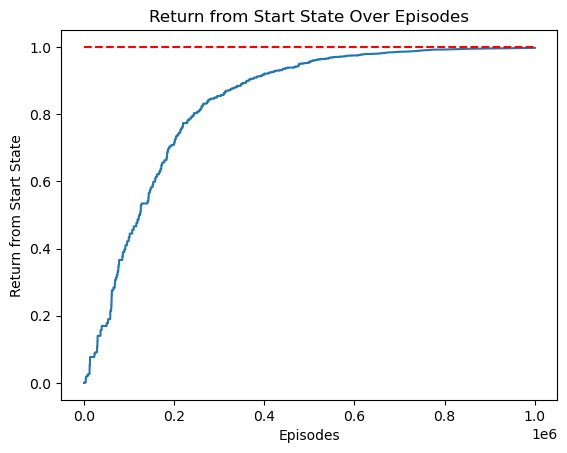

In [90]:
policy, Q, history_without_teacher, bellman_errors_without_teacher, value_errors_without_teacher = qlearning_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, play_against_optimal_until=0)
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_without_teacher)

### Self play with optimal opponent for a few iterations

- The optimal opponent acts as a guide or teacher for a few iterations just to show the agent a few tricks
- For other games this can be changed to human experience if optimal strategies are not known
- This is done to reduce the iterations wasted on exploring extremely bad policies

- We must not use the optimal guide for too many iterations because that would be cheating, the goal is not to build an agent for Nim(which obviously never outperforms the known optimal strategy) but to look at methods to deal with building RL agents for games

100%|██████████| 1000000/1000000 [00:54<00:00, 18332.99it/s]


Q values at start state: {(0, 3): 0.9972777499105672, (1, 1): 0.9964440481959844, (2, 3): 0.9971916157984616, (2, 5): 0.9977316083849737, (0, 1): 0.9959940643012718, (1, 5): 0.9963789595528094, (1, 2): 0.9963967156038145, (0, 4): 0.996538913828766, (1, 4): 0.9959105325410006, (2, 2): 0.9977694606462302, (0, 5): 0.9977197838294679, (2, 1): 0.9958389087946738, (2, 4): 0.9935469813253284, (1, 3): 0.9956101852175704, (0, 2): 0.9958311067283742}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


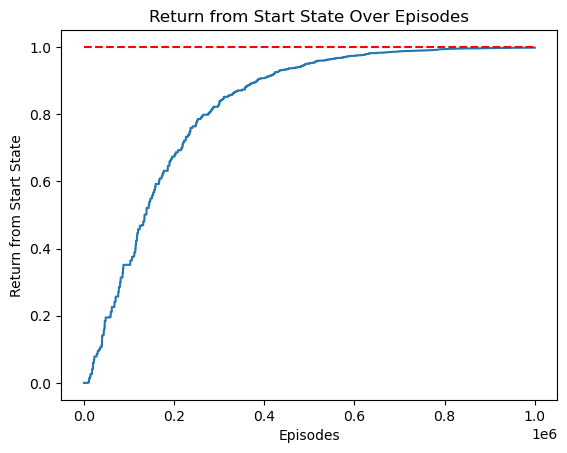

In [91]:
policy, Q, history_with_teacher, bellman_errors_with_teacher, value_errors_with_teacher = qlearning_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, play_against_optimal_until=10000, max_episodes=max_episodes)
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_with_teacher)

In [92]:
# Suboptimal opponent with negative rewards on loss
policy, Q, history_qlearning_suboptimal_opp, bellman_errors_qlearning_suboptimal_opp, value_errors_qlearning_suboptimal_opp = qlearning(sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6)
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:32<00:00, 30326.62it/s]

Q values at start state: {(1, 2): 0.7555505980869033, (2, 3): 0.7275400155242304, (2, 1): 0.7407771618939729, (2, 5): 0.9963998822880556, (0, 5): 0.9966607307492658, (0, 4): 0.6591165618722868, (2, 4): 0.7007323513387081, (1, 5): 0.9948259400429982, (0, 1): 0.7475690051251226, (2, 2): 0.7773073474067662, (1, 4): 0.6981860168063974, (0, 2): 0.738754676697298, (0, 3): 0.7334545670592092, (1, 3): 0.7480180999940654, (1, 1): 0.7239963693602702}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


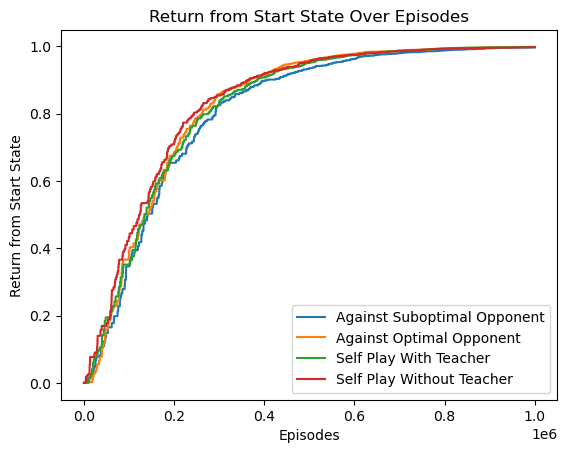

In [93]:
plt.plot(history_qlearning_suboptimal_opp, label='Against Suboptimal Opponent')
plt.plot(history_qlearning, label='Against Optimal Opponent')
plt.plot(history_with_teacher, label='Self Play With Teacher')
plt.plot(history_without_teacher, label='Self Play Without Teacher')
plt.xlabel('Episodes')
plt.ylabel('Return from Start State')
plt.title('Return from Start State Over Episodes')
plt.legend()
plt.show()

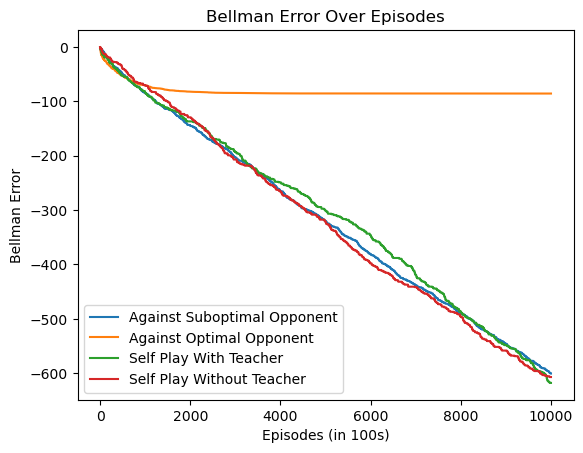

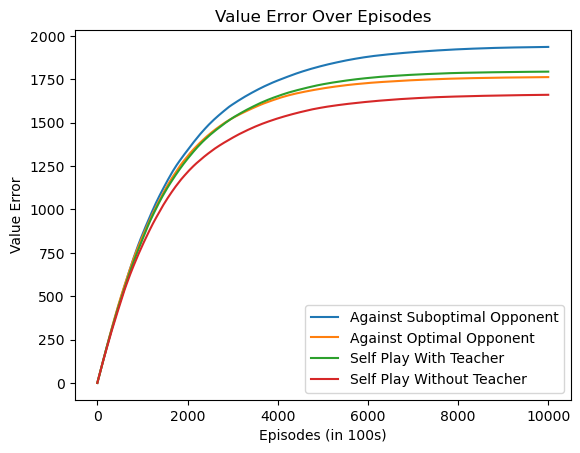

In [94]:
# Same plots for bellman errors and value errors
plt.plot(bellman_errors_qlearning_suboptimal_opp, label='Against Suboptimal Opponent')
plt.plot(bellman_errors_qlearning, label='Against Optimal Opponent')
plt.plot(bellman_errors_with_teacher, label='Self Play With Teacher')
plt.plot(bellman_errors_without_teacher, label='Self Play Without Teacher')
plt.xlabel('Episodes (in 100s)')
plt.ylabel('Bellman Error')
plt.title('Bellman Error Over Episodes')
plt.legend()
plt.show()
plt.plot(value_errors_qlearning_suboptimal_opp, label='Against Suboptimal Opponent')
plt.plot(value_errors_qlearning, label='Against Optimal Opponent')
plt.plot(value_errors_with_teacher, label='Self Play With Teacher')
plt.plot(value_errors_without_teacher, label='Self Play Without Teacher')
plt.xlabel('Episodes (in 100s)')
plt.ylabel('Value Error')
plt.title('Value Error Over Episodes')
plt.legend()
plt.show()

### Self Play with exploring starts
- Against an optimal opponent, exploring starts performs very bad and shows almost no sign of improving or converging even with over 1e6 iterations
- But what if we try it with self play?

In [95]:
policy, Q, history_qlearning_self_play_no_es, bellman_errors_qlearning_self_play_no_es, value_errors_qlearning_self_play_no_es = qlearning_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, play_against_optimal_until=10000, max_episodes=max_episodes, exploring_starts=False)
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [01:10<00:00, 14154.86it/s]

Q values at start state: {(2, 1): -0.9603999984132378, (0, 1): -0.18364523926638082, (1, 1): -0.9799999983826594}
number of fumbles: 85
total number of winning positions: 106
percentage of winning positions fumbled: 80.19 %


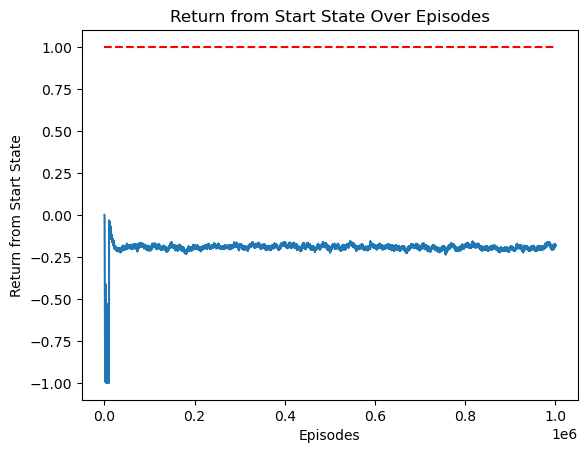

In [96]:
plot_start_state_returns(history_qlearning_self_play_no_es)

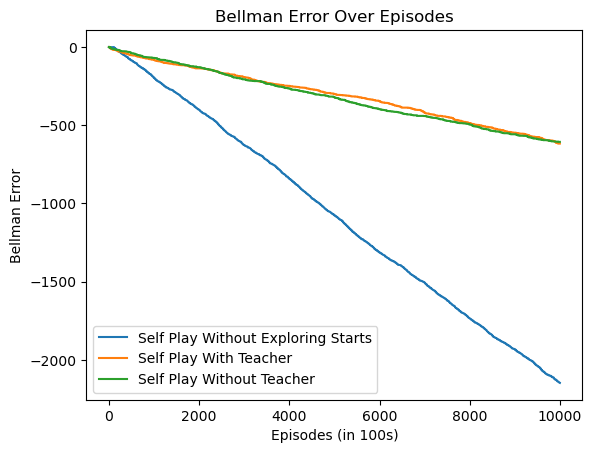

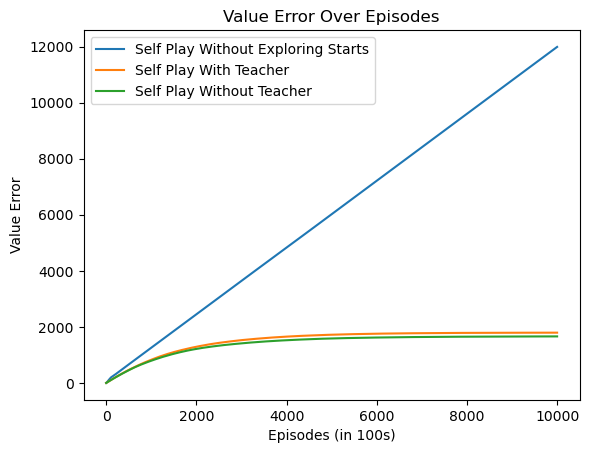

In [98]:
# Compare the performance of self-play with and without exploring starts in terms of bellman errors and value errors
plt.plot(bellman_errors_qlearning_self_play_no_es, label='Self Play Without Exploring Starts')
plt.plot(bellman_errors_with_teacher, label='Self Play With Teacher')
plt.plot(bellman_errors_without_teacher, label='Self Play Without Teacher')
plt.xlabel('Episodes (in 100s)')
plt.ylabel('Bellman Error')
plt.title('Bellman Error Over Episodes')
plt.legend()
plt.show()
plt.plot(value_errors_qlearning_self_play_no_es, label='Self Play Without Exploring Starts')
plt.plot(value_errors_with_teacher, label='Self Play With Teacher')
plt.plot(value_errors_without_teacher, label='Self Play Without Teacher')
plt.xlabel('Episodes (in 100s)')
plt.ylabel('Value Error')
plt.title('Value Error Over Episodes')
plt.legend()
plt.show()

In [ ]:
# Self play with SARSA(lambda)
def sarsa_lambda_self_play(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, epsilon_schedule_update=None, play_against_optimal_until=100, lamb=0.2):
    Q = {} # take default to be zero

    Q_opponent = {}  # Q-values for the opponent

    Q_history = []  # To keep track of the Q-value over episodes for plotting
    E = {}  # Eligibility traces

    regret = [] # To track the regret for each episode

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            if i > play_against_optimal_until:
                R, S1 = sample_step(game, A, Q_opponent=Q_opponent)
            else:
                R, S1 = sample_step(game, A, Q_opponent=None)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}

            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]
            if S not in E:
                E[S] = {}
            if A not in E[S]:
                E[S][A] = 0
            E[S][A] += 1  # Increment eligibility trace for the current state-action pair
            # Update all state-action pairs
            for s in Q:
                for a in Q[s]:
                    if s not in E:
                        E[s] = {}
                    if a not in E[s]:
                        E[s][a] = 0

                    # Update Q-value using eligibility trace
                    Q[s][a] += step_size * delta * E[s][a]

                    # Decay eligibility traces
                    E[s][a] *= lamb * gamma

            A = A1
            S = game.get_state()

        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        elif epsilon_schedule is not None: policy.update(epsilon_schedule[i])
        else: policy.update(1/(i+1))  # Default epsilon value if no schedule is provided

        # Update opponent's Q-values: Best policy until now
        Q_opponent = compareQ(Q, Q_opponent, num_games=10000)

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

        # Track the Regret for every 100 episodes
        if i % 100 == 0:
            regret_value = find_regret_against_optimal(Q, start_state, policy, reward_on_loss=(-1.0 if sample_step == sample_step_reward_zero_on_loss else 0.0))
            regret.append(regret_value + regret[-1] if regret else regret_value)

    return policy, Q, Q_history, regret

In [100]:
# policy, Q, history, regret = sarsa_lambda_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, epsilon_schedule=get_exponential_schedule(decay=0.3), play_against_optimal_until=0)
# evaluate_using_fumbles(policy, Q)
# plot_start_state_returns(history)